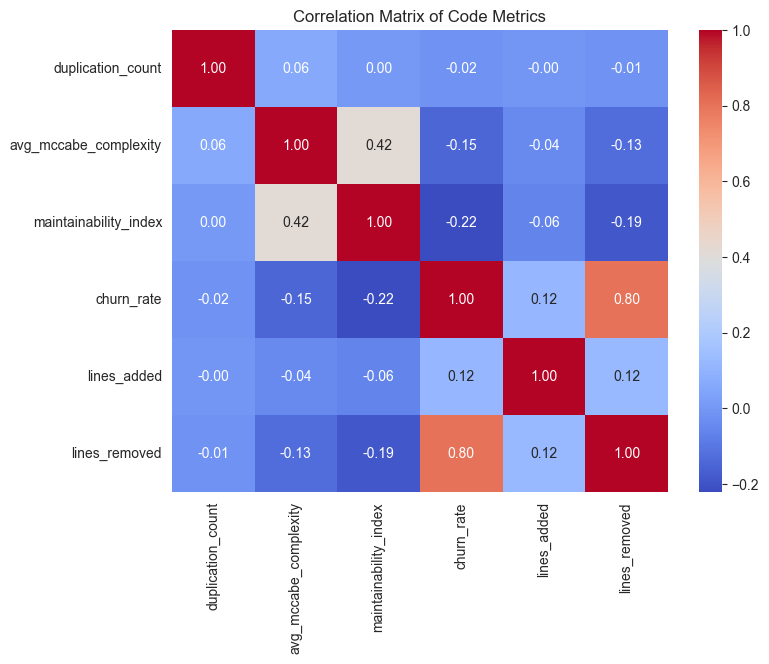

In [3]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load code duplication data
cpd_file_path = "reports/cpd_results.csv"
with open(cpd_file_path, "r") as f:
    lines = [next(f) for _ in range(10)]  # Read first 10 lines

duplication_counts = defaultdict(int)
for line in lines[1:]:  # Skip header
    parts = line.strip().split(",")
    num_occurrences = int(parts[1])
    file_paths = parts[4::3]  # Every third element starting from index 4 contains file paths
    for file_path in file_paths:
        duplication_counts[file_path] += 1

duplication_df = pd.DataFrame(list(duplication_counts.items()), columns=["file", "duplication_count"])

# Load McCabe complexity data
mccabe_file_path = "reports/mccabe.json"
with open(mccabe_file_path, "r") as f:
    mccabe_data = json.load(f)

mccabe_df = []
for file, items in mccabe_data.items():
    complexities = [item["complexity"] for item in items]
    avg_complexity = np.mean(complexities) if complexities else 0
    mccabe_df.append({"file": file, "avg_mccabe_complexity": avg_complexity})

mccabe_df = pd.DataFrame(mccabe_df)

# Load maintainability index data
maintainability_file_path = "reports/maintainability_index.json"
with open(maintainability_file_path, "r") as f:
    maintainability_data = json.load(f)

maintainability_df = pd.DataFrame.from_dict(maintainability_data, orient="index").reset_index()
maintainability_df.columns = ["file", "maintainability_index", "rank"]

# Load code churn data
churn_file_path = "reports/code_churn.csv"
churn_df = pd.read_csv(churn_file_path)
churn_df.rename(columns={churn_df.columns[0]: "file", churn_df.columns[1]: "churn_rate"}, inplace=True)

# Merge all datasets
merged_df = duplication_df.merge(mccabe_df, on="file", how="outer")
merged_df = merged_df.merge(maintainability_df[["file", "maintainability_index"]], on="file", how="outer")
merged_df = merged_df.merge(churn_df, on="file", how="outer")
merged_df.fillna(0, inplace=True)

# Compute correlation matrix
correlation_matrix = merged_df.drop(columns=["file"]).corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Code Metrics")
plt.show()

